In [1]:
""" Importing relevant libraries """
import matplotlib.pyplot as plt
import numpy as np
from math import ceil
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

plt.style.use("seaborn")

$\textbf{Brief case summary}$

The following is mainly for quick reference, taken from the problem text cited at the end of the project.

The concentration of $CO_2$ will be studied through the diffusion equation:
\begin{equation}
\frac{\partial C(z, t)}{\partial t} = \frac{\partial}{\partial z} \left[K(z)\frac{\partial C(z, t)}{\partial z}\right]
\end{equation}

Where $C(z, t)$ describes the dissolved inorganic carbon (DIC) for one column function of time and depth beneath the surface of the ocean.

Regarding the flux, we will use the boundary conditions:

\begin{equation}
j_D = -K(z)\frac{\partial C(z, t)}{\partial z} = 0
\end{equation}
(no flux at the ocean floor)

\begin{equation}
j_{mt} = -k_w(C_0-C_{eq})
\end{equation}
(flux proportional to $\Delta C$ at the surface)

$j$ describes the respective flux, $C_{eq}$ describes the equilibrium concentration of $CO_2$ and $C_0$ is the concentration at $z = 0$, that is the surface.

Further assumptions include:
- $CO_2$ is immediately transformed into DIC when it enters the ocean.
- There is a linear relationship between the partial pressure of $CO_2$ in the atmosphere and the equilibrium concentration of DIC, using the values $p_{CO_2} = 416\cdot 10^{-6}$ and $C_0 = 2.1 mol/m^3$ (Henry's law)
- The equilibrium concentration is given by
$C_{eq} = Hp_{CO_2}$
where $H = 5060 mol/m^3$
- The mass transfer coefficient is parametrized as
$k_w = au^2 = 6.96\cdot10^{-5} m/s$
where $u$ is the wind speed and $a$ is a constant

$\textbf{PDE solving}$

The problem at hand involves solving a PDE, which can be done using the following formulae (referencing the problem text):

\begin{equation}
\boldsymbol{LC}^{i+1} - \frac{1}{2}\boldsymbol{S}^{i+1} = \boldsymbol{RC}^{i} - \frac{1}{2}\boldsymbol{S}^{i}
\end{equation}

\begin{equation}
\boldsymbol{S}^{i} = \left[2\Gamma C_{eq}^{i}, 0, 0, ..., 0 \right]^T
\end{equation}

\begin{equation}
\alpha = \frac{\Delta t}{2(\Delta z)^2}
\end{equation}

\begin{equation}
\Gamma = 2\alpha k_w\Delta z \left(1 - \frac{K_1 - K_0}{2K_0} \right)
\end{equation}

Where the matrices $\boldsymbol{L}$ and $\boldsymbol{R}$ are defined as the tridiagonal matrices:

\begin{equation}
\boldsymbol{L} = 
\begin{bmatrix}
1 + 2\alpha K_0 + \Gamma & -2\alpha K_0 & 0 & \ldots & 0 & 0 & 0
\\ \frac{\alpha}{4} K'_1 - \alpha K_1 & 1 + 2\alpha K_1 & -\frac{\alpha}{4} K'_1 - \alpha K_1 & \ldots & 0 & 0 & 0
\\ 0 & \frac{\alpha}{4} K'_2 - \alpha K_2 & 1 + 2\alpha K_2 & \ldots & 0 & 0 & 0
\\ \vdots & \vdots & \vdots & \ddots & \vdots & \vdots & \vdots
\\ 0 & 0 & 0 & \ldots & 1 + 2\alpha K_{N-2} & -\frac{\alpha}{4} K'_{N-2} - \alpha K_{N-2} & 0
\\ 0 & 0 & 0 & \ldots & \frac{\alpha}{4} K'_{N-1}- \alpha K_{N-1} & 1 + 2\alpha K_{N-1} & -\frac{\alpha}{4} K'_{N-1} - \alpha K_{N-1}
\\ 0 & 0 & 0 & \ldots & 0 & -2\alpha K_N & 1 + 2\alpha K_N
\end{bmatrix}
\end{equation}

That is:
\begin{equation}
L_{nn} = 1 + 2\alpha K_n
\end{equation}
\begin{equation}
L_{n(n-1)} = \frac{\alpha}{4} K'_n - \alpha K_n
\end{equation}
\begin{equation}
L_{n(n+1)} = -\frac{\alpha}{4} K'_n - \alpha K_n
\end{equation}

with special cases at $L_{00}$, $L_{01}$ and $L_{N(N-1)}$

\begin{equation}
\boldsymbol{R} = 
\begin{bmatrix}
1 - 2\alpha K_0 - \Gamma & 2\alpha K_0 & 0 & \ldots & 0 & 0 & 0
\\ -\frac{\alpha}{4} K'_1 + \alpha K_1 & 1 - 2\alpha K_1 & \frac{\alpha}{4} K'_1 + \alpha K_1 & \ldots & 0 & 0 & 0
\\ 0 & -\frac{\alpha}{4} K'_2 + \alpha K_2 & 1 - 2\alpha K_2 & \ldots & 0 & 0 & 0
\\ \vdots & \vdots & \vdots & \ddots & \vdots & \vdots & \vdots
\\ 0 & 0 & 0 & \ldots & 1 - 2\alpha K_{N-2} & \frac{\alpha}{4} K'_{N-2} + \alpha K_{N-2} & 0
\\ 0 & 0 & 0 & \ldots & -\frac{\alpha}{4} K'_{N-1}+ \alpha K_{N-1} & 1 - 2\alpha K_{N-1} & \frac{\alpha}{4} K'_{N-1} + \alpha K_{N-1}
\\ 0 & 0 & 0 & \ldots & 0 & 2\alpha K_N & 1 - 2\alpha K_N
\end{bmatrix}
\end{equation}

That is:
\begin{equation}
R_{nn} = 1 - 2\alpha K_n
\end{equation}
\begin{equation}
R_{n(n-1)} = -\frac{\alpha}{4} K'_n + \alpha K_n
\end{equation}
\begin{equation}
R_{n(n+1)} = \frac{\alpha}{4} K'_n + \alpha K_n
\end{equation}

again with special cases at $R_{00}$, $R_{01}$ and $R_{N(N-1)}$.

We also define
- $K_n = K(z_n)$
- $K'_n = K_{n+1} - K_{n-1}$ (which is valid for $n \in [1, N-1]$)

$\textbf{Implementation}$

I have chosen to implement the relevant functions and variables object-oriented. The reason is that there are a lot of variables to keep track off, and an object-oriented approach will make it easier to organize everything. First, the class DIC is implemented, which was developed throughout the problem solving. Afterwards, the code is written for each task using the implementations in the class DIC.

In [2]:
""" Setup """

class DIC:
# The class takes in the time- and distance steps dt and dz, as well as some other relevant variables for some functions.

    def __init__(self, dz, dt, params = (180*24*60**2, 100, "K1")):
    # Params is a tuple consisiting of (T (max time), L (ocean depth), string describing K(z). K1 = K(z) from problem one, and all other string        values will give K(z) from problem two.)    

        assert(isinstance(params, tuple) or isinstance(params, list)) # Checking that params is of type tuple or list.
        self.__variables(dz, dt, params)
        self.__matrices(dz)

    
    def __variables(self, dz, dt, params):
    # Private method that implements mathematical functions an constants.

        self.__k_w = 6.97e-5 # m / s         # Mass transfer coefficient.
        self.Len = params[1] # m             # Relevant ocean depth.
        self.z = np.arange(0, self.Len, dz)  # Array of z-values.
        self.N = len(self.z)                 # Amount of unique points z.
        self.last_sol = np.zeros(self.N)     # Variable that contains the last solution calculated.
        if params[2] == "K1": # Constructing K(z) from problem one:
            K_0 = 1e-3    # m^2 / s
            K_a = 2e-2    # m^2 / s
            z_a = 7       # m
            K_b = 5e-2    # m^2 / s
            z_b = 10      # m
            self.K = lambda z: K_0 + K_a * (z/z_a) * np.exp(-z/z_a) + K_b * ((self.Len - z)/z_b) * np.exp(-(self.Len - z)/z_b) # K(z)
        else: # Constructing K(z) from problem 2:
            K_0 = 1e-4    # m^2 / s
            K_1 = 1e-2    # m^2 / s
            a   = 0.5     # m^-1
            z_0 = 100     # m
            self.K = lambda z: K_1 + (K_0 - K_1)/(1 + np.exp(-a*(z-z_0)))

        self.dz = dz
        self.dt = dt
        self.define_time(dt, params[0])


    def define_time(self, dt, T):
    # This function allows us to redefine the time steps after class construction, as the matrix generation is independent of T. dt must remain        the same. The function is also used for initialization of relevant variables.

        self.T = T  # s      # Time end
        self.t = np.arange(0, T + self.dt, self.dt)
        self.Q = len(self.t) # Amount of time steps.


    def __matrices(self, dz):
    # Private method that defines the matrices L and R and adding them as class variables.

        # K_n = self.K(self.z) # K_n as list of z_n
        K_n = self.K(self.z)
        K_p = self.wrap_zeros(K_n[2:] - K_n[:-2]) # K' (see definition of wrap_zeros())

        # Other constants:
        alpha = self.dt / (2*dz**2)
        Gamma = 2*alpha*self.__k_w*dz*(1 - (K_n[1] - K_n[0]) / (2*K_n[0]))

        N = self.N
        L_data, R_data = [np.array([np.zeros(N-1), np.zeros(N), np.zeros(N-1)]) for _ in range(2)] # List for L and R diagonals.
        offset = np.array([-1, 0, 1])

        # Diagonal matrix list construction:
        L_data[2] = alpha*(-K_p/4 - K_n) # Upper diagonal L.
        L_data[2][0] = -2*alpha*K_n[0]
        L_data[2] = self.remove_index(L_data[2], -1)

        L_data[1] = 1 + 2*alpha*K_n # Mid diagonal L.
        L_data[1][0] += Gamma

        L_data[0] = alpha*(K_p/4 - K_n) # Lower diagonal L.
        L_data[0][-1] = -2*alpha*K_n[-1]
        L_data[0] = self.remove_index(L_data[0], 0)


        R_data[2] = alpha*(K_p/4 + K_n) # Upper diagonal R.
        R_data[2][0] = 2*alpha*K_n[0]
        R_data[2] = self.remove_index(R_data[2], -1)

        R_data[1] = 1 - 2*alpha*K_n # Mid diagonal R.
        R_data[1][0] -= Gamma

        R_data[0] = alpha*(-K_p/4 + K_n) # Lower diagonal R.
        R_data[0][-1] = 2*alpha*K_n[-1]
        R_data[0] = self.remove_index(R_data[0], 0)


        # Construction and adding variables as class members:
        self.__Gamma = Gamma
        self.L = diags(L_data, offset)
        self.R = diags(R_data, offset)
        # L and R are sparse matrices, which store only three arrays for the diags and has custom functions for matrix operations built into               Scipy. This makes them considerably faster than regular numpy ndarrays.

    
    def solve(self, C_eq, C = [None]):
    # Solves the system of equations based on an array-like object C_eq with dimension Q, representing the concentration

        if C[0] == None: C = np.zeros(self.N) # Cannot access self in default parameters, therefore we use a condition in the function.
        Cs = np.zeros((self.Q, self.N))       # ndarray for all values of C through all the time steps. This takes a small toll on preformance,                                                  but is very useful for later problems.
        Cs[0] = C                             # Initializing C_0.

        S = np.zeros((self.Q, self.N))        # Construction of S for all timesteps.
        for i in range(len(S)): S[i][0] = 2*self.__Gamma*C_eq[i]
        
        # Solution:
        for i in range(1, self.Q):
            V = self.R.dot(Cs[i-1]) + (S[i-1] + S[i]) / 2
            Cs[i] = spsolve(self.L, V)
        
        self.Cs = Cs  # Adding all values of C as class variable.
        return Cs     # Returns all values of C for potential external treatment.


    def TotalMass(self):
    # Returns an array of the total DIC mass in kg for every timestep.

        assert(any(self.Cs[-1])) # Check that a solution exists.
        
        molar_m = 1.2e-2 # kg / mol   # Molar mass of carbon.
        surface_area = 360e12 # m^2   # Surface area of all of earths oceans.
        masses = np.zeros(self.Q)     # Variable containing a list of the masses for each timestep.
        for i in range(self.Q):
            masses[i] = Simpson(self.Cs[i], self.dz)*molar_m*surface_area # Using Simpsons method to integrate the DIC concentration, then                                                                                   converting to kg.
        
        self.masses = masses

    
    def plot_sol(self, inds = [-1], time_unit = "years", fig = 1):
    # Plots the solution. inds contains the indices of timesteps to plot together. By default, only the last timestep value is plotted.
    # time_unit must be either years (standard) or days. It determines the time unit of the labels for each graph.

        assert(any(self.Cs[-1])) # Check that a solution exists.'

        # Variables for labeling of time unit:
        if time_unit == "days":
            tu = 24*60**2
        elif time_unit == "years":
            tu = 365*24*60**2
        else : raise Exception("Invalid time unit")

        # Plotting:
        plt.figure(fig)
        for i in inds:           # Plotting C-values for all the indices.
            plt.plot(self.Cs[i], self.z, label = f"t = {round(self.t[i]/tu, 1)} {time_unit}")
        plt.legend()
        plt.xlabel("DIC concentration [mol/m$^3$]")
        plt.ylabel("Depth [m]")
        plt.title("DIC concentration in ocean column")


    def plot_min_max(self, fig = 3):
    # Plots the minimum and maximum values of C for all timesteps as a function of time.

        assert(any(self.Cs[-1])) # Check that a solution exists.

        Cmax = np.array([np.max(el) for el in self.Cs]) # Determening maximum values for each timestep.
        Cmin = np.array([np.min(el) for el in self.Cs]) # Determening minimum values for each timestep.
        t = self.t/(60**2*24)                           # Converting time from seconds to days.

        plt.figure(fig)
        plt.plot(t, Cmax, label = "Max($C_i$)")
        plt.plot(t, Cmin, label = "Min($C_i$)")
        plt.xlabel("t [days]")
        plt.ylabel("DIC concentration [mol/m$^3$]")
        plt.title("Min and max values for DIC concentrations")
        plt.legend()
    

    def plot_TotalMass(self, fig = 4):
    # Plots the values in the "masses" class variable.

        assert(any(self.masses))  # Check that masses are constructed.

        t = self.t/(60**2*24*365) # Converting time from seconds to years.
    
        plt.figure(fig)
        plt.plot(t, self.masses)
        plt.xlabel("t [years]")
        plt.ylabel("Total DIC [kg]")
        plt.title(f"Total DIC mass over {round(t[-1])} years")


    def disp_matrices(self, imshow = False):
    # Displays matrices with or without an imshop plot. Mainly for testing purposes.

        L, R = self.L.toarray(), self.R.toarray() # Converting matrices to numpy arrays.

        print(f"z = {self.z}")
        print(f"\nL = \n{L}")
        print(f"\nR = \n{R}")

        if imshow:
            plt.figure(2)
            fig, ax = plt.subplots(ncols=2, figsize = (12,6))
            for i, el in enumerate([[L, "L"], [R, "R"]]): # Using imshow:
                ax[i].imshow(el[0], cmap = plt.cm.bwr, vmin = -1, vmax = 1)
                ax[i].set_title(el[1])


    @staticmethod # Keyword implying that the function is not exclusive to a specific object.
    def wrap_zeros(arr):
    # Takes in a numpy array and adds 0 to front and back.

        arr = np.insert(arr, 0, 0)
        arr = np.append(arr, 0)
        return arr

    @staticmethod
    def remove_index(arr, ind):
    # Removes index ind from arr and returns arr. This method is slow, but it is more safe than to use than built in numpy functions such as           remove(), and it will only be used a few times per class construction.

        n = len(arr)
        if ind < 0:
            ind = n - ind
        new_arr = np.array([])
        for i in range(n):
            if not i == ind:
                new_arr = np.append(new_arr, arr[i])
        return new_arr


def Simpson(f_vals, h):
# Uses simpsons method to integrate f_vals. If len(f_vals) is odd, there will be some error.

    # List operation to add 4 times every odd element and 2 times every even element (except at the extremums):
    integral = f_vals[0] + 4*sum(f_vals[1::2]) + 2*sum(f_vals[2::2])
    if not len(f_vals) % 2:
        # If f_vals has an even number of elements, we must subtract 3*f_end.
        integral -= 3*f_vals[-1]
    
    return integral * (h/3)

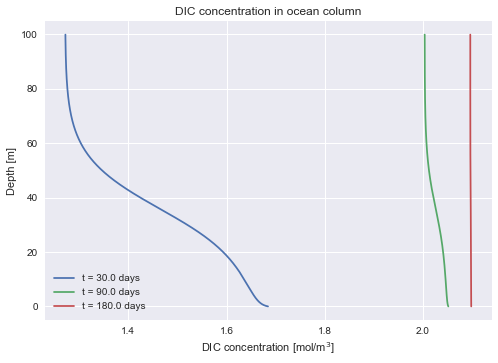

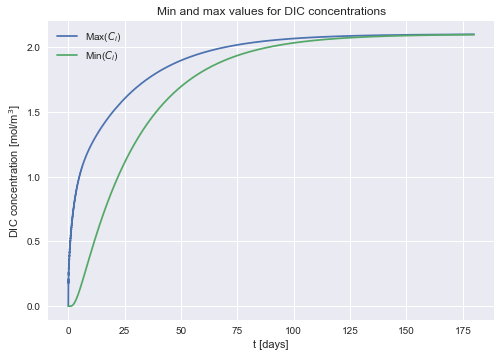

In [3]:
""" Problem 1 """

# Defining relevant constants:
dz = 0.1           # m
dt = 60**2 / 2     # s       # Calculations will be relatively fast with this timestep, and we will also get sufficient accuracy.
T = 180*24*60**2   # s
H   = 5060         # mol / (m^3*atm)
p_C = 415e-6       # atm   Partial pressure of CO_2 in the atmosphere.
# We will plot for t = 30 days, 90 days and 180 days: 
day_index = T/(180*dt)
inds = [int(day_index*i) for i in [30, 90]] + [-1]


# Execution:
sys1 = DIC(dz, dt)                       # Construction an instance of our class.
C_eq = H*p_C*np.ones(sys1.Q)             # Array of C_eq with constant values.
Cs = sys1.solve(C_eq)                    # Calculation the DIC concntration solution.
sys1.plot_sol(inds, time_unit = "days")  # Plotting the solution for t = 30, 90 and 180 days.
sys1.plot_min_max()                      # Plotting the minimum and maximum values.

$\textbf{Problem 1: Discussion}$

It is very clear from the plots that the DIC concentration evens out in the shallow ocean relatively quickly. It also appears to approach the equilibrium very fast, which is not surprising considering that the change in time $\frac{\partial C}{\partial t}$ is proportional to the amount of curvature in $C(z)$ which is minimized as $C$ approaches equilibrium, as can be seen in the first graph.

To conclude, it is clear that there is a small delay between the atmospheric partial pressure of $CO_2$, however it is very small for shallow waters when we consider large timeframes of magnitude years or decades, as we would when we analyze earth's climate.

$\textbf{Problem 2: Theory}$

A somewhat more realistic and applicable model is now considered; one with varying $C_{eq}$ at deep ocean. The climate changes very rapidly, so assuming constant values for $C_{eq}$ would be a cause for marginal error. The depth of 4000 meters will be used.


First, we must look at the mathematical background for the development of atmospheric $CO_2$. We assume $C_{eq}(t=0) = C_{eq0} = Hp_{CO_2}(0)$ which is the value for $p_{CO_2}$ used in problem 1. Further, it is given:
\begin{equation}
\frac{dp_{CO_2}}{dt} = 2.8 ppm/yr = 8.88 \cdot 10^{-14} atm/s
\end{equation}
\begin{equation}
\rightarrow
C_{eq}(t) = C_{eq0} + H\frac{dp_{CO_2}}{dt}t
\end{equation}

In this model, the equilibrium concentration of $CO_2$ in 2030 is
\begin{equation}
C_eq(t = 30 yrs) = 2.1 mol/m^3
\end{equation}

This assumption is of course unrealistic. It is more reasonable to expect that the atmospheric $CO_2$ will continue to grow exponentially unless we are able to take action related to climate change. It is unlikely to grow linearly either way, but it can be used as an approximate.

Results:
Mass consumed per year (scientific estimate): 2.500000e+13 kg
Mass consumed per year (our calculations)   : 1.450496e+13 kg
Error from scientific estimate              : 1.049504e+13 kg

Graphs:


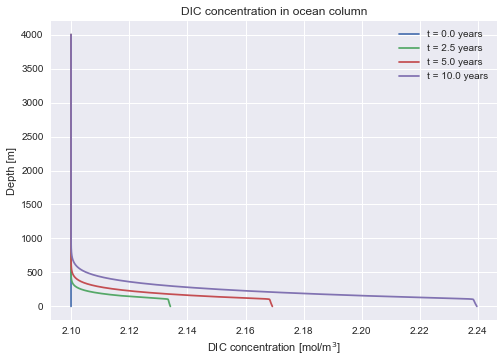

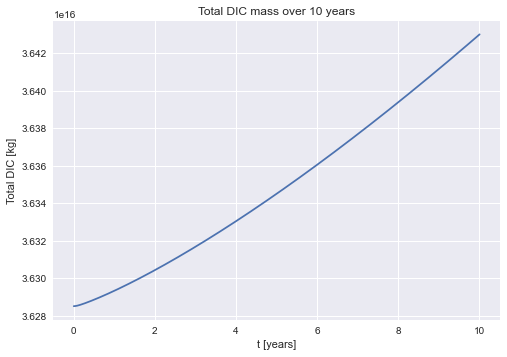

In [4]:
""" Problem 2 """

# Defining relevant constants. dz remains the same as in Problem 1.
nyears = 10             # years    # Number of years to iterate.
dt = 3*24*60**2         # s        # Since we are estimating over a 20 times larger period and a 40 times larger distance than in problem 1, we                                       must also use larger timesteps for acceptable run time.
T = nyears*365*24*60**2 # s
sys2 = DIC(dz, dt, (T, 4e3, "K2")) # Creation the DIC class instance, now with different values for params (see definition in DIC.__init__()).
year_index = T/(nyears*dt)         # Approximation of indices in sys2.t for each year.
inds = [int(ceil(year_index*i)) for i in [0, 2.5, 5, 10]] # List of indices in sys2.t for 0, 2.5, 5 and 10 year marks.

C_eq_2 = C_eq[0] + H*8.88e-14 * sys2.t # Creation of C_eq values from the equation above. Using the values for C_eq from problem 1 as C_eq(0).
C = C_eq[0] * np.ones(sys2.N)          # Assuming equilibrium, C(0) = C_eq(0)


# Execution:
sys2.solve(C_eq_2, C)    # Calculation the DIC concntration solution.
sys2.plot_sol(inds)      # Plotting the solution.
sys2.TotalMass()         # Calculation of the total mass by integrating DIC concentration for all columns in the ocean.
sys2.plot_TotalMass()    # Plotting the calculated total mass.


# Comparison with scientific estimate:
print("Results:")
sci_est = 2.5e13 # kg  # The scientific estimate of consumed carbon mass.
yearly_consumed_mass = round((sys2.masses[-1] - sys2.masses[0])/nyears, 2) # kg  # Average value of yearly consumed mass
pred_error = abs(sci_est - yearly_consumed_mass) # kg
# Converting values to strings with scientific formatting:
sci_est_string = "{:e}".format(sci_est)
yearly_consumed_mass_string = "{:e}".format(yearly_consumed_mass)
pred_error_string = "{:e}".format(pred_error)
# Printing:
print(f"Mass consumed per year (scientific estimate): {sci_est_string} kg")
print(f"Mass consumed per year (our calculations)   : {yearly_consumed_mass_string} kg")
print(f"Error from scientific estimate              : {pred_error_string} kg")
print("\nGraphs:")

$\textbf{Problem 2: Discussion}$

Based on the uppermost plot and figure 2 in the problem text (NTNU, 2021, p. 4), it appears that the turbulence is effective until about 300 m, when it suddenly cuts off as is expected considering the choice of $K(z)$. Deeper levels have a much slower rate of diffusion.

Concerning the comparison of the result with Grubers anthropogenic $CO_2$ estimate, it is clear that the water column model underestimates the amount of $CO_2$ absorbed. The model naturally includes both the anthropogenic $CO_2$ and that which would be absorbed if the $CO_2$ would remain at pre-industrial levels (around 280 ppm according to figure 3 in the problem text (NTNU, 2021, p. 5)). It is clear from the lowermost plot that the consumption does not have a linear relationship to the partial pressure of $CO_2$ (we can tell because the plot, unlike the value of $p_{CO_2}$ seems to have a somewhat quadratic or hyperbolic form). Therefore, one cannot estimate the amount of non-anthropogenic $CO_2$ to compare with Grubers estimate without modifying or changing the model. It is possible, however, to conclude that the water column model does not have great accuracy, but can still give a very rough estimate of the magnitude of $CO_2$ consumption. Possible causes of the error will be discussed in the following section.

$\textbf{Error analysis}$

The water column model is relatively simple, both physically and mathematically, and Python also has somewhat limited capabilities as compared to other faster programming languages. Some of the main causes for error include:
- The one-dimensional diffusion equation is applied with diffusivity described by $K(z)$. Turbulence is a naturally three-dimensional phenomena, and there is a limit to how well it can be described by the one-dimensional function $K(z)$. In problem 2, this is handled by a sigmoid function, making the diffusivity large near the surface then have it suddenly drop (see plots below). This simplification is likely a cause for considerable error.
- The 1D model also neglects the exchange of DIC with other columns, for example as a cause of subsurface currents.
- The mathematical model includes relatively simple discretization of the differentiated values of $K(z)$. This will not necessarily be a large cause for error as compared to other factors, but can affect the results to some degree.
- All of the numerical methods are accompanied by some error whose analysis is beyond the scope of TMA4320. The exception is Simpsons method which has an error formula given by $\frac{b-a}{180}h^4\cdot f^{(4)}(c)$. It is clear that there is not much curvature in the DIC concentration graph (where Simpsons method was used), so it is reasonable to assume that $f^{(4)}(c)$ is a small value, although this is very hard to actually estimate. Also, $h^4=0.1^4=10^{-4}$ is relatively small. Thus, one can safely neglect the error of Simpsons method when compared to the error from the choice of model and the other numerical methods.
- Python is a slow programming language compared to faster languages such as C++, and the numerics are done on a regular private computer. Therefore, there is a limit to how small time- and spacial steps we can use. To counter this limitation, the use of scipy sparse matrices and numpy arrays have helped considerably.
- The assumption of linear growth of p_{CO_2} is likely a cause for error as is briefly stated in the theory section for problem 2.

$\textbf{Conclusion}$

The water column models is effective to give a general magnitude of the consumed $CO_2$, as well as displaying the concentration of consumed carbon as a function of both depth and time. It is, however, not effective to give the accurate predictions that are needed for climate-related planning and research. For these purposes, more advanced mathematical physical models must be applied.

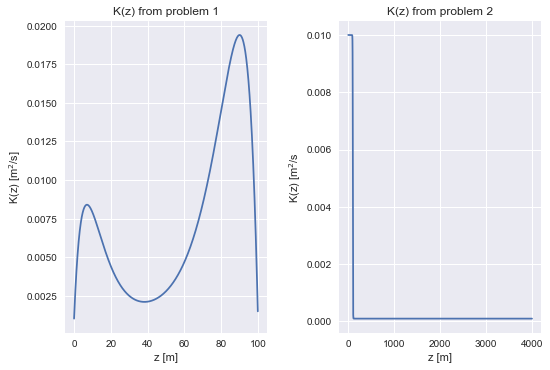

In [5]:
""" Plotting K(z) for reference """

plt.subplot(121)
plt.plot(sys1.z, sys1.K(sys1.z))
plt.xlabel("z [m]")
plt.ylabel("K(z) [m$^2$/s]")
plt.title("K(z) from problem 1")
plt.subplot(122)
plt.plot(sys2.z, sys2.K(sys2.z))
plt.xlabel("z [m]")
plt.ylabel("K(z) [m$^2$/s")
plt.title("K(z) from problem 2")

plt.tight_layout(pad=2)

$\textbf{Citations}$

NTNU. (2017). Project 1: One-dimensional diffusion model for CO2 absorption in the ocean. Retrieved from Blackboard.